In [ ]:
# Auto Encoder기반 Anomaly Detection 코드 실행에 필요한 라이브러리
from utils import *
from usad import *

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf

In [ ]:
# 앞서 이산 웨이블릿 변환한 데이터를 불러온다.
# 이산 웨이블릿 변환한 데이터를 column별로 시각화한 결과, cD3열의 데이터가 이상이 발생했을을 때와 평소를 가장 잘 구분하므로 이 열의 데이터를 활용한다.
data_path = './dwt/'

data1_1 = pd.read_csv(data_path + "Bearing1_1_dwt.csv",usecols=['h_cD3', 'v_cD3'])

In [ ]:
data1_1.head()

,h_cD3,v_cD3
0,3.325501,0.898459
1,3.631342,0.755240
2,1.820052,1.017333
3,1.665085,1.035748
4,1.439624,0.948676


In [ ]:
data1_1.shape

(2802, 2)

In [ ]:
# 값을 0~1사이의 값으로 Scaling한다.
from sklearn import preprocessing
min_max_scaler = preprocessing.MinMaxScaler()

x = data1_1.values
x_scaled = min_max_scaler.fit_transform(x)
scaled_data = pd.DataFrame(x_scaled)

In [ ]:
scaled_data.head(2)

,0,1
0,0.052356,0.012069
1,0.058861,0.008623


In [ ]:
#########################################
#                학습코드                 #
#########################################

In [ ]:
window_size=12

In [ ]:
window_size=12
windows_normal=scaled_data.values[np.arange(window_size)[None, :] + np.arange(scaled_data.shape[0]-window_size)[:, None]]
windows_normal.shape

(2790, 12, 2)

In [ ]:
BATCH_SIZE = 32
N_EPOCHS = 100
hidden_size = 10

w_size=windows_normal.shape[1]*windows_normal.shape[2]
z_size=windows_normal.shape[1]*hidden_size

windows_normal_train = windows_normal[:400]
windows_normal_test = windows_normal[400:]

In [ ]:
windows_normal_train_re = windows_normal_train.reshape(windows_normal_train.shape[0], w_size)
windows_normal_test_re = windows_normal_test.reshape(windows_normal_test.shape[0], w_size)
windows_normal_re = windows_normal.reshape(windows_normal.shape[0], w_size)

In [ ]:
windows_normal_train_re = windows_normal_train_re.astype('float32')
windows_normal_test_re = windows_normal_test_re.astype('float32')
windows_normal_re = windows_normal_re.astype('float32')

In [ ]:
import torch.utils.data as data_utils

train_loader = torch.utils.data.DataLoader(windows_normal_train_re,batch_size=BATCH_SIZE)
test_loader = torch.utils.data.DataLoader(windows_normal_test_re,batch_size=BATCH_SIZE)
whole_loader = torch.utils.data.DataLoader(windows_normal_re,batch_size=BATCH_SIZE)

In [ ]:
model_usad = UsadModel(w_size, z_size)
model_usad = to_device(model_usad,device)

In [ ]:
def trainings(epochs, model, train_loader, val_loader, opt_func=torch.optim.Adam):
    history = []
    optimizer1 = opt_func(list(model.encoder.parameters())+list(model.decoder1.parameters()))
    optimizer2 = opt_func(list(model.encoder.parameters())+list(model.decoder2.parameters()))
    for epoch in range(epochs):
        for batch in train_loader:
            batch=to_device(batch,device)

            #Train AE1
            loss1,loss2 = model.training_step(batch,epoch+1)
            loss1.backward()
            optimizer1.step()
            optimizer1.zero_grad()
            
            
            #Train AE2
            loss1,loss2 = model.training_step(batch,epoch+1)
            loss2.backward()
            optimizer2.step()
            optimizer2.zero_grad()
            
        result = evaluates(model, val_loader, epoch+1)
        model.epoch_end(epoch, result)
        history.append(result)
    return history

def evaluates(model, val_loader, n):
    outputs = [model.validation_step(to_device(batch,device), n) for batch in val_loader]
    return model.validation_epoch_end(outputs)

In [ ]:
history = trainings(N_EPOCHS,model_usad,train_loader,test_loader)

Epoch [0], val_loss1: 0.2200, val_loss2: 0.2048
Epoch [1], val_loss1: 0.2057, val_loss2: -0.0000
Epoch [2], val_loss1: 0.1952, val_loss2: -0.0629
Epoch [3], val_loss1: 0.1850, val_loss2: -0.0895
Epoch [4], val_loss1: 0.1740, val_loss2: -0.1010
Epoch [5], val_loss1: 0.1618, val_loss2: -0.1042
Epoch [6], val_loss1: 0.1485, val_loss2: -0.1024
Epoch [7], val_loss1: 0.1345, val_loss2: -0.0973
Epoch [8], val_loss1: 0.1202, val_loss2: -0.0904
Epoch [9], val_loss1: 0.1059, val_loss2: -0.0822
Epoch [10], val_loss1: 0.0922, val_loss2: -0.0735
Epoch [11], val_loss1: 0.0796, val_loss2: -0.0649
Epoch [12], val_loss1: 0.0679, val_loss2: -0.0564
Epoch [13], val_loss1: 0.0576, val_loss2: -0.0487
Epoch [14], val_loss1: 0.0490, val_loss2: -0.0420
Epoch [15], val_loss1: 0.0413, val_loss2: -0.0358
Epoch [16], val_loss1: 0.0351, val_loss2: -0.0307
Epoch [17], val_loss1: 0.0300, val_loss2: -0.0264
Epoch [18], val_loss1: 0.0257, val_loss2: -0.0228
Epoch [19], val_loss1: 0.0223, val_loss2: -0.0199
Epoch [20],

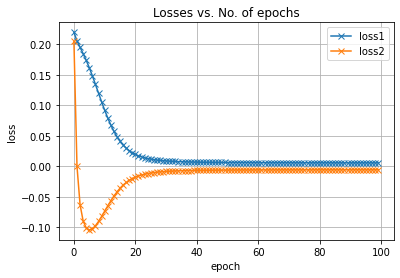

In [ ]:
plot_history(history)

In [ ]:
# 학습된 모델을 가지고 예측을 하는 함수
def testings(model, test_loader, alpha=.5, beta=.5):
    results=[]
    for batch in test_loader:
        batch=to_device(batch,device)
        w1=model.decoder1(model.encoder(batch))
        w2=model.decoder2(model.encoder(w1))
        results.append(alpha*torch.mean((batch-w1)**2,axis=1)+beta*torch.mean((batch-w2)**2,axis=1))
    return results

In [ ]:
# 수집된 전체 데이터에 대해서 예측을 진행한다.
a = testings(model_usad,whole_loader)
a_cpu=[]
for i in range(len(a)):
  a_cpu.append(a[i].detach().cpu())
a = np.concatenate([np.stack(a_cpu[:-1]).flatten(), a_cpu[-1].flatten()])

# train데이터에 대해서 예측 결과를 생성한다.
b = testings(model_usad,train_loader)
b_cpu=[]
for i in range(len(b)):
  b_cpu.append(b[i].detach().cpu())
b = np.concatenate([np.stack(b_cpu[:-1]).flatten(), b_cpu[-1].flatten()])

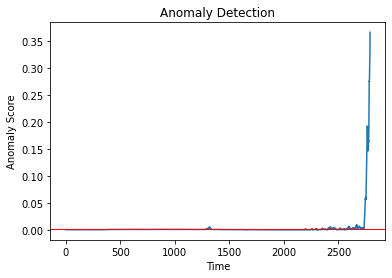

In [ ]:
# Train데이터에 대해 예측된 값을 바탕으로 Threshold값을 정하고 이 값이 넘는 값은 이상치로 판단한다.
from matplotlib import pyplot as plt

plt.plot([x for x in range(a.shape[0])], a)
plt.axhline(y=b.mean() + 5 * b.std(), color='r', linewidth=1)
plt.title('Anomaly Detection')
plt.xlabel('Time')
plt.ylabel('Anomaly Score')
plt.show()

In [ ]:
# Threshold
b.mean() + 5 * b.std()

0.06151166930794716

In [ ]:
#이상치가 아닌 값의 개수
start_idx = np.max(np.where(a < b.mean() + 5 * b.std())[0]); start_idx

2789

In [ ]:
#이상치의 개수
a_ = a[:1895]
np.where(a_ > b.mean() + 5 * b.std())[0].shape

(18,)